<a href="https://colab.research.google.com/github/juankuntz/parem_tf/blob/master/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%%capture
# Load drive:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False) # Mount drive to VM in colab

In [2]:
# Import github repo:
import sys
!rm -rf parem_tf
!git clone https://github.com/juankuntz/parem_tf.git  
REPOSITORY_PATH = '/content/parem_tf'
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

Cloning into 'parem_tf'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 68 (delta 27), reused 57 (delta 16), pack-reused 0
Unpacking objects: 100% (68/68), 15.95 KiB | 907.00 KiB/s, done.


In [3]:
# Import modules:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from parem_tf.src import models, decoders

# Model training

To start, let's load the first $10,000$ images of the MNIST dataset to train our model with:

In [4]:
(x, _), (_, _) = tf.keras.datasets.mnist.load_data()
x = x[:10000].astype('float32')[..., np.newaxis]
data = tf.data.Dataset.from_tensor_slices(x)

Next, let's define the model, starting with the decoder (taken from [here](https://keras.io/examples/generative/vae/)):

In [5]:
latent_dimensions = 32  
decoder = decoders.get_simple_decoder(latent_dimensions)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                           

We can now define the entire model:

In [6]:
pae = models.ParticleAutoencoder(latent_dimensions=latent_dimensions,
                                 decoder=decoder,
                                 observation_noise_std=1e-2)

To train it we use:
- $10$ particles,
- a step size of $0.0005$ to update the latent variables,
- and an RMSProp optimizer to update the decoder's parameters.

Given that the de

In [7]:
pae.compile(lv_learning_rate=1e-3/2, n_particles=10,
            optimizer=tf.keras.optimizers.RMSprop(),
            preprocessor=tf.keras.layers.Rescaling(scale=1./255),
            postprocessor=tf.keras.layers.Rescaling(scale=255.))

Train model:

In [24]:
history = pae.fit(data=data, epochs=10, batch_size=1024)  

Epoch 1/10
9/9 [==============================] - 4s 420ms/step - loss: 11716.9993
Epoch 2/10
9/9 [==============================] - 4s 422ms/step - loss: 11609.7162
Epoch 3/10
9/9 [==============================] - 4s 427ms/step - loss: 11521.6328
Epoch 4/10
9/9 [==============================] - 4s 425ms/step - loss: 11405.3509
Epoch 5/10
9/9 [==============================] - 4s 426ms/step - loss: 11429.3266
Epoch 6/10
9/9 [==============================] - 4s 428ms/step - loss: 11173.2019
Epoch 7/10
9/9 [==============================] - 4s 431ms/step - loss: 11206.6361
Epoch 8/10
9/9 [==============================] - 4s 432ms/step - loss: 11231.0498
Epoch 9/10
9/9 [==============================] - 4s 433ms/step - loss: 11104.4162
Epoch 10/10
9/9 [==============================] - 4s 434ms/step - loss: 11031.2114


# Visualize posterior

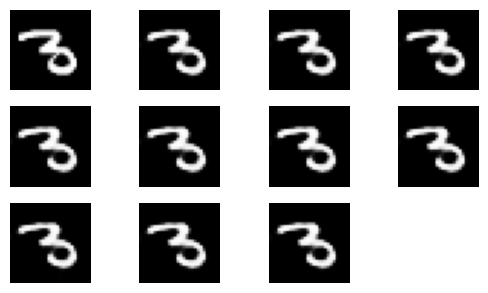

In [25]:
def plot_images(images):
  grid_size = math.ceil(len(images) ** (1/2))
  for i, image in enumerate(images):
      ax = plt.subplot(grid_size, grid_size, i + 1)
      plt.imshow(255 - image.astype("uint8"), cmap='Greys')
      plt.axis("off")
  plt.show()

i = 30
samples = pae.decode_posterior_samples(n_samples=10, index=i)
images = [x[i, ..., 0]] + [samples[i, ...].numpy()[..., 0] for i in range(samples.shape[0])]
plot_images(images)

# Generate fakes

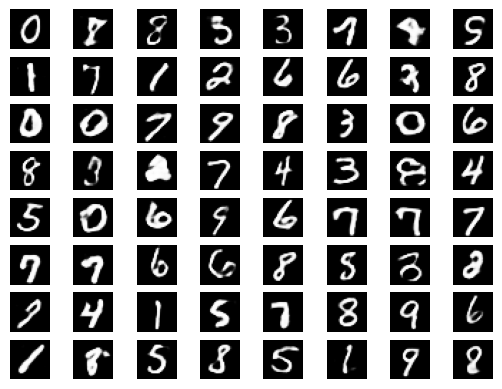

In [26]:
fakes = pae.generate_fakes(n_fakes=64)  # n_components=500
plot_images([fakes[i, ...].numpy()[..., 0] for i in range(fakes.shape[0])])